<h1 style="color:rgb(0,120,170)">Assignment 2: Solving memory task using the RNN</h1>

Author: Frederik Kratzert

**Deadline: 17.11.2019 23:59**

In this excercise we will use the RNN implemented in the previous assignment to solve the memory task. The task is to remember the first element in the input sequence. That is, given a sequence of random numbers, the RNN should output at the last time step the first element of the input sequence.This can be framed as a regression task. 

To solve this assignment you have to implement the following things:
1. Implement a generator that yields unlimimted training batches for the memory task.
2. Implement the mean squared error loss function and its derivative to be able to compute the gradients of the loss w.r.t. the network parameters.
3. Implement a learner class to facilitate the model training.
4. Train models for different sequence lengths and test up to which sequence length you are able to train the RNN succesfully. Visualize your results.
5. Visualize the vanishing gradient problem.

Copyright statement:  
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and
non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in
parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the
authors.

<h3 style="color:rgb(200,0,0)">Please fill in</h3> 

Your Name: **Nicolas Kirchmayr**   
Student number: **k11938826** 

In [1]:
from collections import defaultdict
from typing import Tuple, Generator, Dict

import matplotlib.pyplot as plt
import numpy as np
import tqdm

<h2 style="color:rgb(0,120,170)">Modified RNN implementation</h2>

In the last assignment your task was to implement a RNN forward and backward pass that works on a single input sequence. In reality, what you want to do most of the time is training using mini-batches of data samples. That is, you don't do the forward and backward pass for a single sample and then update your weights, but instead do the forward and backward pass for _n_ samples at the same time and calculate the average gradients of the _n_ samples for the weight update.  
What you see below is our example solution of last weeks assignment, which will also work for mini-batch training and can be used in this assignment.

In [2]:
class RNN(object):
    """Numpy implementation of sequence-to-one recurrent neural network for regression tasks."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """Initialization 

        Parameters
        ----------
        input_size : int
            Number of input features per time step
        hidden_size : int
            Number of hidden units in the RNN
        output_size : int
            Number of output units.
        """
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # create and initialize weights of the network
        self.W = np.zeros((input_size, hidden_size))
        self.R = np.zeros((hidden_size, hidden_size))
        self.bs = np.zeros((hidden_size, 1))
        self.V = np.zeros((hidden_size, output_size))
        self.by = np.zeros((output_size, 1))
        self.reset_parameters()

        # place holder to store intermediates for backprop
        self.a = None
        self.y_hat = None
        self.grads = None
        self.x = None

    def reset_parameters(self):
        """Weight initialization
        
        Initialize the recurrent weights as identity matrix and the input to hidden
        and hidden to output weights using the LeCun initialization.
        """
        # recurrent weights initialized as identity matrix
        self.R = np.eye(self.hidden_size)
        
        # input to hidden and hidden to output initialized with LeCun initialization
        gain = np.sqrt(3 / self.input_size)
        self.W = np.random.uniform(-gain, gain, self.W.shape)
        gain = np.sqrt(3 / self.hidden_size)
        self.V = np.random.uniform(-gain, gain, self.V.shape)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward pass through the RNN.

        Parameters
        ----------
        x : np.ndarray
            Input sequence(s) of shape [sequence length, batch size, number of features]

        Returns
        -------
        NumPy array containing the network prediction for each sample in the input data.
        """
        seq_length, batch_size, _ = x.shape

        self.a = np.zeros((seq_length+1, batch_size, self.hidden_size))

        a_0 = np.zeros((batch_size, self.hidden_size))
        self.a[-1] = a_0.copy()

        for t in range(seq_length):
            s_t = np.dot(x[t], self.W) + np.dot(self.a[t-1], self.R) + self.bs.T
            a_t = np.tanh(s_t)
            self.a[t] = a_t
        
        y_hat = np.dot(a_t, self.V) + self.by.T
        self.y_hat = y_hat.copy()
        self.x = x.copy()

        return y_hat

    def backward(self, d_loss: np.ndarray) -> Dict:
        """Calculate the backward pass through the RNN.
        
        Parameters
        ----------
        d_loss : np.ndarray
            The gradient of the loss w.r.t the network output in the shape [batch_size, output_size]

        Returns
        -------
        Dictionary containing the gradients for each network weight as key-value pair.
        """
        seq_length, _, _ = self.x.shape

        # track gradients of weight matrices
        d_V = np.zeros_like(self.V)
        d_by = np.zeros_like(self.by)
        d_R = np.zeros((seq_length, *self.R.shape))
        d_W = np.zeros((seq_length, *self.W.shape))
        d_bs = np.zeros((seq_length, *self.bs.shape))
        
        for t in reversed(range(seq_length)):
            if t == seq_length - 1:
                d_V = np.dot(self.a[t].T, d_loss)
                d_a = np.dot(d_loss, self.V.T)
                d_by = d_loss.sum(axis=0).reshape(self.by.shape)
            else:
                d_a = d_a_next
            
            d_s = d_a * (1 - self.a[t]*self.a[t])
            d_W[t] = np.dot(self.x[t].T, d_s)
            d_R[t] = np.dot(self.a[t-1].T, d_s)
            d_bs[t] = d_s.sum(axis=0).reshape(d_bs[t].shape)

            d_a_next = np.dot(d_s, self.R.T)

        self.grads = {'d_V': d_V, 'd_W': d_W, 'd_R': d_R, 'd_bs': d_bs, 'd_by': d_by}
        
        return self.grads
        
    def update(self, lr: float):
        """Updat the network parameter.
        
        Note: By convention (for numerical stabilization) the average (instead
        of the sum) gradient over time is used for updating the recurrent weights.

        Parameters
        ----------
        lr : float
            Learning rate used for the weight update
        """
        if not self.grads:
            raise RuntimeError("You have to call the .backward() function first")
            
        for key, grad in self.grads.items():
            if len(grad.shape) == 3:
                self.grads[key] = grad.sum(axis=0)
                
        self.W -= lr*self.grads['d_W']
        self.R -= lr*self.grads['d_R']
        self.V -= lr*self.grads['d_V']
        self.bs -= lr*self.grads['d_bs']
        self.by -= lr*self.grads['d_by']

        # reset internal class attributes
        self.grads = {}
        self.y_hat, self.a = None, None
        
    def get_weights(self) -> Dict:
        """Return dictionary containing the weight matrices
        
        Returns
        -------
        Dictionary containing the network weights as key-value pairs.
        """
        return {'W': self.W, 'R': self.R, 'V': self.V, 'bs': self.bs, 'by': self.by}
    
    def set_weights(self, weights: Dict):
        """Set the network weights.
        
        Parameters
        ----------
        weights : Dict
            Dictionary containing one key-value pair for each network weight.
        """
        if not all(name in weights.keys() for name in ['W', 'R', 'V']):
            raise ValueError("Missing one of 'W', 'R', 'V' keys in the weight dictionary")
        self.W = weights["W"]
        self.R = weights["R"]
        self.V = weights["V"]
        self.bs = weights["bs"]
        self.by = weights["by"]

<h2 style="color:rgb(0,120,170)">Excercise 1: Implement Datagenerator</h2>

Here you should implement a Python Generator function that, given a `batch size` and a `sequence length`, returns two arrays, `x` and `y`. `x` is a batch of randomly generated input sequences of shape [sequence length, batch size, 1] and `y` the array of target values, which is the first sequence element for each sample in the batch.

In [3]:
def generate_samples(batch_size: int, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """Data generator for memory task
    
    Note: Implement this function as a Python generator.
    
    Parameters
    ----------
    batch_size : int
        Number of samples in one batch
    seq_length : int
        Length of sequence of random numbers
        
    Returns
    -------
    x : np.ndarray
        Array of shape [sequence length, batch size, 1], where each sample is a sequence
        of random generated numbers between -1 and 1.
    y : np.ndarray
        Array of shape [batch size, 1], where each element i contains the label corresponding
        to sample i of the input array. The label is the first element of the sequence.
    
    """
    ########################
    # Your code comes here #
    ########################
    while True:
        x = np.random.uniform(low=-1, high=1,size=(seq_length, batch_size, 1))
        y = x[0,:,:].copy()
        yield (x,y)

Use the code below to validate your implementation. No modifications required

In [4]:
batch_size = 256
seq_length = 20
data_generator = generate_samples(batch_size=batch_size, seq_length=seq_length)
x, y = next(data_generator)
assert np.all(x[0,:,:] == y)
assert x.shape[0] == seq_length
assert x.shape[1] == batch_size
assert x.shape[2] == 1
assert y.shape[0] == x.shape[1]
assert y.shape[1] == 1
print("Data generator works as expected")

Data generator works as expected


<h2 style="color:rgb(0,120,170)">Excercise 2: Implement MSE Loss</h2>

Since the memory task is a regression type of task, we will use the mean squared error (MSE) as our loss function. Similar to the RNN class object, you should implement the MSE loss as a class having a `forward` and `backward` function (see the class skelleton below).

To validate your implementation, use the two-sided numerical gradient approximation again and check against your analytical gradients. 

Note: The gradient check here is much simpler to implement, compared to the last excercise, since you can apply the small variations directly to the `y_hat` entries (the network predictions).

In [5]:
class MSELoss(object):
    def __init__(self):
        super(MSELoss, self).__init__()
        self.y_hat = None
        self.y_true = None
        
    def forward(self, y_hat: np.ndarray, y_true: np.ndarray) -> float:
        """Calculate the MSE loss
        
        Parameters
        ----------
        y_hat : np.ndarray
            Array containing the network predictions of shape [batch_size, 1]
        y_true : np.ndarray
            Array containing the true values of shape [batch_size, 1]
        
        Returns:
        The mean square error as a floating number.
        """
        #######################################################################
        # Your code comes here.                                               # 
        # Hint: Again, you have to store certain variables that are needed in #
        # in the backward pass                                                # 
        #######################################################################
        self.y_hat = y_hat
        self.y_true = y_true
        return np.mean((y_hat - y_true)**2)
        raise NotImplementedError
    
    def backward(self) -> np.ndarray:
        """Calculate the backward pass of the MSE
        
        Returns
        -------
        The gradient w.r.t the network output of shape [batch_size, 1]
        """
        if (self.y_hat is None) or (self.y_true is None):
            raise RuntimeError("You have to call the .forward() function first")
            
        ########################
        # Your code comes here #
        ########################
        return 2*(self.y_hat - self.y_true)/self.y_hat.shape[0]
        raise NotImplementedError

In [6]:
def get_numerical_gradient(loss_obj: MSELoss, y_hat: np.ndarray, y_true: np.ndarray,
                           eps: float=1e-7) -> np.ndarray:
    """Calculate the two-sided numerical gradient approximation.
    
    Parameters
    ----------
    loss_obj : MSELoss
        The MSELoss object
    y_hat : np.ndarray
        The network prediction of shape [batch size, number of outputs]
    y_true : np.ndarray
        The true target values of shape [batch size, number of outputs]
    eps : float
        The pertubations applied to the network predictions, by default 1e-7
   
    Returns
    -------
    A NumPy array containing the numerically approximated gradients.
    """
    numerical_gradients = np.zeros_like(y_hat)
    #########################################################################
    # TODO: Implement the two-sided numerical gradient approximation.       #
    # The specifications of the in- and output are defined in the docstring.#                                                  #
    #########################################################################
    for i in range(numerical_gradients.shape[0]):
        y_hat[i] += eps
        out_plus = loss_obj.forward(y_hat, y_true)
        y_hat[i] -= 2*eps
        out_minus = loss_obj.forward(y_hat, y_true)
        y_hat[i] += eps
        numerical_gradients[i] = (out_plus - out_minus)/(2*eps)
    return numerical_gradients
    raise NotImplementedError


def get_analytical_gradient(loss_obj: MSELoss, y_hat: np.ndarray, 
                            y_true: np.ndarray) -> np.ndarray:
    """Calculate the analytically derived gradients.
    
    Parameters
    ----------
    loss_obj : MSELoss
        The MSELoss object
    y_hat : np.ndarray
        The network prediction of shape [batch size, number of outputs]
    y_true : np.ndarray
        The true target values of shape [batch size, number of outputs]
        
    Returns
    -------
    A NumPy array containing the analytically derived gradients.
    """        
    _ = loss_obj.forward(y_hat, y_true)
    analytical_grads = loss_obj.backward()
    return analytical_grads

            
def gradient_check(loss_obj: MSELoss, y_hat: np.ndarray, y_true: np.ndarray, 
                   threshold: float = 1e-7):
    """Perform the gradient check.
    
    Parameters
    ----------
    loss_obj : MSELoss
        The MSELoss object
    y_hat : np.ndarray
        The network prediction of shape [batch size, number of outputs]
    y_true : np.ndarray
        The true target values of shape [batch size, number of outputs]
    threshold : float
        Threshold for the difference between the numerical and analytical gradients.
        By default 10e-7.
        
    """            
    numerical_grads = get_numerical_gradient(loss_obj, y_hat, y_true)
    analytical_grads = get_analytical_gradient(loss_obj, y_hat, y_true)

    difference = np.linalg.norm(numerical_grads - analytical_grads)
    if difference < threshold:
        print(f"Gradient check passed (difference {difference:.3e})")
    else:
        print(f"Gradient check failed (difference {difference:.3e})")

In [7]:
loss_obj = MSELoss()
y_hat = np.random.rand(256, 1)
y_true = np.random.rand(256, 1)
gradient_check(loss_obj, y_hat, y_true)

Gradient check passed (difference 1.387e-09)


<h2 style="color:rgb(0,120,170)">Excercise 3: Implement Learner class</h2>

The task of this excercise is to implement a setup for training the RNN. That is, given the data generator from above, setup a model and connect the outputs to the MSELoss, channel the gradient of the MSELoss into the backward pass of the RNN and monitor the loss during training.

For this you should complete the methods of the class `Learner` below. 

In [8]:
class Learner(object):
    def __init__(self, model: RNN, loss_obj: MSELoss, data_generator: Generator):
        """The initialization method
        
        Parameters
        ----------
        model : RNN
            An instance of the NumPy RNN implementation.
        loss_obj: MSELoss
            An instance of the mean squared error loss class.
        data_generator : Generator
            The data generator function implemented above
        """
        self.model = model
        self.loss_obj = loss_obj
        self.data_generator = data_generator
        
        self.loss_values = {}
        self.y_hats = None
        self.y_trues = None
        
    def train(self, iter_steps: int, lr: float, log_steps: int = 50):
        """The training method.
        
        This function implements the training loop for a given number of
        iteration steps.
        
        Parameters
        ----------
        iter_steps : int
            Number of training iteration steps.
        lr : float
            Learning rate used for the weight update.
        log_steps : int
            Interval to log the training loss, by default 50.
        """
        if not self.loss_values:
            start_step = 0
        else:
            start_step = list(self.loss_values.keys())[-1]
        pbar = tqdm.tqdm_notebook(self.data_generator, total=iter_steps)
        for x, y in pbar:
            pbar.update()
            if pbar.n < iter_steps:
                ##################################################
                # Your code comes here:                          #
                # Hint: One training step consists of a forward, #
                # the backward and the weight update step.       #
                ##################################################
                y_hat = self.model.forward(x)
                loss = self.loss_obj.forward(y_hat, y)
                y_hat_grad = self.loss_obj.backward()
                self.model.backward(y_hat_grad)
                self.model.update(lr)
                # log loss value
                if (pbar.n == 1) or (pbar.n % log_steps == 0):
                    self.loss_values[start_step + pbar.n] = loss
                    pbar.set_postfix_str(f"Loss: {loss:5f}")
            else:
                tqdm.tqdm.write("finished training")
                break
    
    def make_predictions(self, n_batches: int) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate predictions for a given number of random batches.
        
        Parameters
        ----------
        n_batches : int
            Number of batches to get networks predictions for.
            
        Returns
        -------
        y_hats : np.ndarray
            NumPy array containing the concatenated network predictions for all batches.
        y_trues : np.ndarray
            NumPy array containing the concatenated true labels for all batches.
        """
        ########################
        # Your code comes here #
        ########################
        x,y = next(data_generator)
        self.y_trues = y
        self.y_hats = self.model.forward(x)
        for i in range(n_batches - 1):
            x,y = next(data_generator)
            np.concatenate((self.y_trues,y))
            np.concatenate((self.y_hats, self.model.forward(x)))
        return self.y_hats, self.y_trues
        raise NotImplementedError
                    
    def plot_loss(self, figsize: Tuple[float, float]=(10, 8)):
        """Plot training loss curve.
        
        Parameters
        ----------
        figsize : Tuple[float, float]
            Matplotlib figure size, by default (10,8)
        """
        if not self.loss_values:
            raise RuntimeError("You have to train the network first.")
            
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(list(self.loss_values.keys()), list(self.loss_values.values()))
        ax.set_xlabel("Weight updates")
        ax.set_ylabel("MSE")
    
    def scatter_plot(self,figsize: Tuple[float, float]=(10, 8)):
        """Scatter plot of true vs predicted values.
        
        Parameters
        ----------
        figsize : Tuple[float, float]
            Matplotlib figure size, by default (10,8)
        """        
        if any(val is None for val in [self.y_hats, self.y_trues]):
            raise RuntimeError("Call the .make_predictions() method first")
    
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(self.y_trues, self.y_hats)
        ax.plot([-1,1], [-1,1], '--', color='k', zorder=0)
        ax.set_xlabel("True values")
        ax.set_ylabel("Predicted values")

Now use everything implemented so far to train your first RNN. To do so, execute the code cell below.

finished training


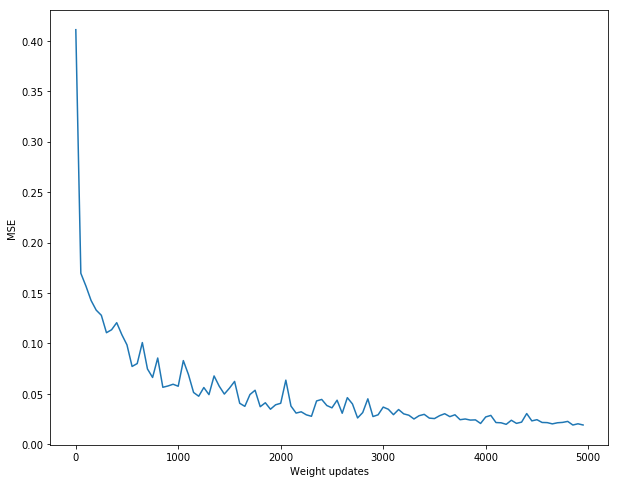

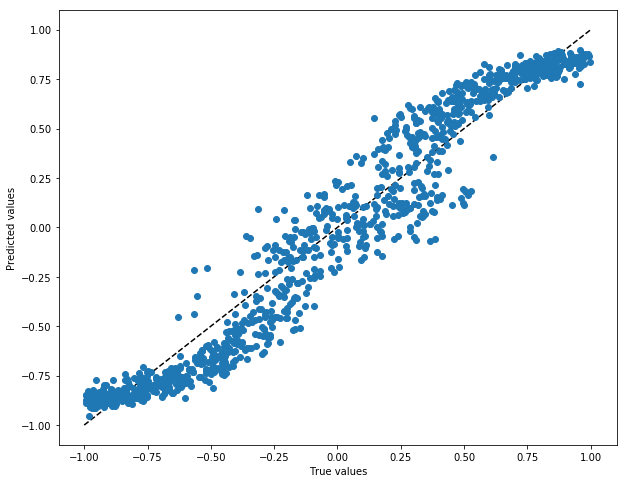

In [14]:
model = RNN(input_size=1, hidden_size=10, output_size=1)
data_generator = generate_samples(batch_size=1024, seq_length=10)

learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator)
learner.train(iter_steps=5000, lr=1e-2, log_steps=50)
learner.plot_loss()
_ = learner.make_predictions(n_batches=1)
learner.scatter_plot()

<h2 style="color:rgb(0,120,170)">Excercise 4: Train RNNs</h2>

Using everything implemented so far you should now be able to train RNNs fairly easily. Go ahead and train RNNs to solve the memory task with different sequence length. Test what is the maximum sequence length you are able to solve with the RNN. For each setting, train multiple repetitions (e.g. 10), to see the effect of the random initialization and visualize this random variations in your plots.

finished training


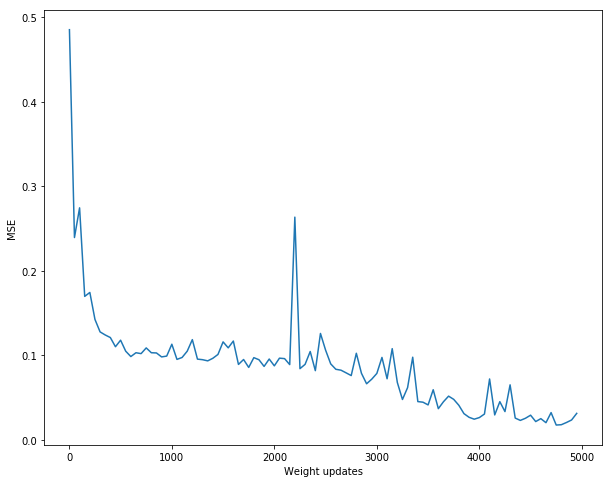

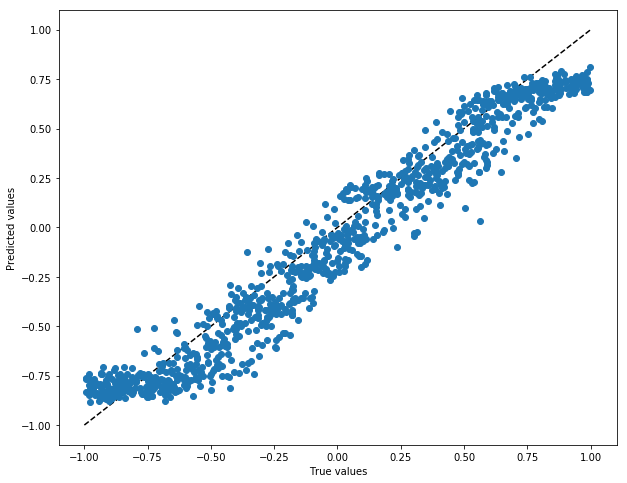

In [13]:
########################
# Your code comes here #
########################
model = RNN(input_size=1, hidden_size=25, output_size=1)
data_generator = generate_samples(batch_size=1024, seq_length=20)

learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator)
learner.train(iter_steps=5000, lr=1e-2, log_steps=50)
learner.plot_loss()
_ = learner.make_predictions(n_batches=1)
learner.scatter_plot()

Visualize the results, including error bars (from the repetitions).

In [ ]:
########################
# Your code comes here #
########################

<h2 style="color:rgb(0,120,170)">Excercise 5: Vanishing Gradient</h2>

In the lecture you have heard that the problem of training RNNs on long sequences is called the vanishing gradient problem. Come up with your own ideas how you can visualize this problem. 

Hint: You could, for example, compare the gradients over time for two different sequence lengths - one sequence length, where the RNN still is able to learn and one, where it does not.

In [ ]:
########################
# Your code comes here #
########################